In [1]:
#%load_ext tensorboard

#import gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.logger import TensorBoardOutputFormat

#from env.capsubot_env import CapsubotEnv
#from env.custom_logger import SummaryWriterCallback

import numpy as np
import matplotlib.pyplot as plt
import time
import datetime, os

In [2]:
import gym
import numpy as np
import pyglet
import scipy.constants
import scipy.integrate
from gym import spaces
from gym.utils import seeding

MIN_VOLTAGE = 0.0
MAX_VOLTAGE = 24.0

MIN_X = -10.0
MAX_X = -MIN_X

MIN_XI = -1.0
MAX_XI = -MIN_XI

MIN_DX = -10.0
MAX_DX = -MIN_DX
MIN_DXI = MIN_DX
MAX_DXI = -MIN_DX


class CapsubotEnv(gym.Env):
    """A cabsubot with electromagnetic coil"""

    metadata = {"render.modes": ["live", "file", "none", "human"]}
    visualization = None

    def __init__(self):
        super(CapsubotEnv, self).__init__()

        self.total_time = None
        self.state = None
        self.average_speed = 0
        self.M = 0.193
        self.m = 0.074
        self.stiffness = 256.23
        self.force_max = 1.25
        self.mu = 0.29  # Coefficient of friction.

        self.steps_in_period = 200
        self.min_period = 0.01
        self.dt = self.min_period / self.steps_in_period  # Action force discritization.
        self.frame_skip = self.steps_in_period  # testing ver where the agent cant't take an action more than one time per min_period
        self.previous_average_speed = 0.0
        self.done = False

        self.action_space = spaces.Discrete(2)

        self.observation_space = spaces.Box(
            low=np.array([MIN_X, MIN_DX, MIN_XI, MIN_DXI]),
            high=np.array([MAX_X, MAX_DX, MAX_XI, MAX_DXI]),
            dtype=np.float32,
        )

        self.viewer = None
        self.seed()

    def seed(self, seed=42):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def normalize_state(self, state: list) -> np.ndarray:
        """
        Normalizing reward states because NN inside RL agent works better with normalized inputs.
        Because we can't know the true thresholds of the model states, we use that wierd interpolation.
        Thresholds were obtained experimetally.
        """
        state = np.array(state)
        norm_state = []
        norm_state.append(np.interp(state[0], [-0.0007666844383611218, 0.07919885629789096], [-1, 1]))
        norm_state.append(np.interp(state[1], [-0.18283166534706963, 0.24274101317295704], [-1, 1]))
        norm_state.append(np.interp(state[2], [-0.01652187660136813, 0.019895362341591866], [-1, 1]))
        norm_state.append(np.interp(state[3], [-1.1832780931204638, 1.1508305412787394], [-1, 1]))
        return np.array(norm_state)

    def F_step(self, action):
        return action * self.force_max

    def friction_model(self, velocity):
        N = (self.M + self.m) * scipy.constants.g
        return -N * 2 / np.pi * np.arctan(velocity * 10e5)
        # return -np.sign(velocity) * N * self.mu

    def mechanical_model(self, y, t, force):
        x, x_dot, xi, xi_dot = y
        friction = self.friction_model(x_dot)
        x_acc = (self.stiffness * xi - force + friction) / self.M
        xi_acc = (-self.stiffness * xi + force) / self.m - x_acc
        return [x_dot, x_acc, xi_dot, xi_acc]
    
    def calc_reward(self, av_speed, prev_av_speed, scale_factor=1000) -> float:
        return (av_speed - prev_av_speed) * scale_factor
            
    def step(self, action, integrator="euler"):
        err_msg = f"{action!r} ({type(action)}) invalid"
        assert self.action_space.contains(action), err_msg

        for _ in range(self.frame_skip):
            x, x_dot, xi, xi_dot = self.state
            
            force = self.F_step(action)

            # Euler kinematic integration.
            dx = self.mechanical_model(self.state, 0, force)
            self.state = [
                x + self.dt * dx[0],
                x_dot + self.dt * dx[1],
                xi + self.dt * dx[2],
                xi_dot + self.dt * dx[3],
            ]

            self.total_time = self.total_time + self.dt
            self.average_speed = x / self.total_time
 
        norm_state = self.normalize_state(self.state)
        # TO DO: normalize reward
        step_reward = self.calc_reward(self.average_speed, self.previous_average_speed)
        self.previous_average_speed = self.average_speed
        
        if x >= 0.05:
            self.done = True  
            step_reward += 500
        elif x <= -0.007:
            self.done = True
            step_reward -= 1000

        return (
            norm_state,
            step_reward,
            self.done,
            {"average_speed": self.average_speed},
        )

    def reset(self):
        self.state = (0, 0, 0, 0)
        self.total_time = 0.0
        self.average_speed = 0.0
        self.previous_average_speed = 0.0
        self.done = False
        return np.array(self.state).astype(np.float32)

    def render(self, mode="human"):
        screen_width = 1280
        screen_height = 400

        capsule_length = 100.0
        capsule_height = 30.0

        world_width = 1.0
        scale = screen_width / world_width

        inner_body_length = capsule_length / 2.0
        inner_body_height = capsule_height
        inner_body_y = capsule_height

        ground_level = 200

        if self.viewer is None:
            from gym.envs.classic_control import rendering

            self.viewer = rendering.Viewer(screen_width, screen_height)
            # Capsule polygon.
            l, r, t, b = (
                -capsule_length / 2,
                capsule_length / 2,
                capsule_height / 2,
                -capsule_height / 2,
            )
            capsule = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.capsule_transform = rendering.Transform()
            capsule.add_attr(self.capsule_transform)
            self.viewer.add_geom(capsule)

            # Inner body polygon
            l, r, t, b = (
                -inner_body_length / 2,
                inner_body_length / 2,
                inner_body_height / 2,
                -inner_body_height / 2,
            )
            inner_body = rendering.FilledPolygon([(l, b), (l, t), (r, t), (r, b)])
            self.inner_body_transform = rendering.Transform()
            inner_body.add_attr(self.inner_body_transform)
            inner_body.add_attr(self.capsule_transform)
            inner_body.set_color(0.8, 0.6, 0.4)
            self.viewer.add_geom(inner_body)

            # Ground surface
            self.track = rendering.Line((0, ground_level), (screen_width, ground_level))
            self.track.set_color(0, 0, 0)
            self.viewer.add_geom(self.track)

            # Score
            self.score_label = pyglet.text.Label(
                "0000",
                font_size=36,
                x=20,
                y=screen_width * 2.5 / 40.00,
                anchor_x="left",
                anchor_y="center",
                color=(255, 255, 255, 255),
            )

        if self.state is None:
            return None

        x, x_dot, xi, xi_dot = self.state
        capsule_x = x * scale + screen_width / 2.0  # MIDDLE OF CART
        capsule_y = ground_level + capsule_height / 2.0  # MIDDLE OF CART
        self.capsule_transform.set_translation(capsule_x, capsule_y)

        inner_body_x = xi * scale  # MIDDLE OF CART
        self.inner_body_transform.set_translation(inner_body_x, inner_body_y)

        self.score_label.text = "%04i" % self.average_speed
        self.score_label.draw()

        return self.viewer.render(return_rgb_array=mode == "rgb_array")

    def close(self):
        if self.viewer:
            self.viewer.close()
            self.viewer = None


In [3]:
class SummaryWriterCallback(BaseCallback):
    def _on_training_start(self) -> None:
        self._log_freq = 100  # log every 100 calls

        output_formats = self.logger.output_formats
        # Save reference to tensorboard formatter object
        # note: the failure case (not formatter found) is not handled here, should be done with try/except.
        self.tb_formatter = next(
            formatter
            for formatter in output_formats
            if isinstance(formatter, TensorBoardOutputFormat)
        )

    def _on_step(self) -> bool:
        if self.n_calls % self._log_freq == 0:
            list_of_speeds = [item.get("average_speed") for item in self.locals.get("infos")]
            average_speed = np.array(sum(list_of_speeds) / len(list_of_speeds))
            self.tb_formatter.writer.add_scalar(
                "average_speed_train/average_speed_mean",
                average_speed,
                self.num_timesteps,
            )
            for i in range(len(list_of_speeds)):
                self.tb_formatter.writer.add_scalar(
                    f"average_speed_train/average_speed_env_{i+1}",
                    list_of_speeds[i],
                    self.num_timesteps,
                )
            self.tb_formatter.writer.flush()
            return True


## Training

#### Some docs
- Обучал на n_envs = 4 -- хорошо работает
- (забавное замечание: при n_envs = 1 и total_timesteps=float(3e5) он выучился использовать готовый закон управления, без переключений)
- без make_vec_env работает, но как-то плохо. Без make_vec_env не то же самое, что и с make_vec_env(lambda: env, n_envs=1). Хз почему

### Just testing some ideas
***
Testing part starts here

#### Notes
***
1. На 1е6 таймстепах без использования векторного энвайронмента робот не двигается
2. А на 3е5 тайстепах заработал, но плохо (тоже без вектор врапппера)
3. На 3е5 таймстепах с make_vec_env(lambda: env, n_envs=1) робот стоит
4. На 3е5 таймстепах с make_vec_env(lambda: env, n_envs=4) робот заметно поехал. Модель сохранил с названием __ppo-CapsuBot-3e5-4envs__
    Примечание: обучил дважды и получил разные результаты
5. На 1е5 таймстепах без использования векторного энв робот не двигается (c make_vec_env(lambda: env, n_envs=1) тоже нет)
6. На 3е6 таймстепах с make_vec_env(lambda: env, n_envs=16) не поехал
7. На 1.5е6 таймстепах с make_vec_env(lambda: env, n_envs=4) выучил какую-то очень странную (но приодическую) зависимость
8. На 3е6 таймстепах с make_vec_env(lambda: env, n_envs=8) выучил, что можно просто включить силу и никогда её не отключать (хороший вариант) (lr=2.5e-4)
***
__version2: self.force = self.F_step(action). Функция возвращает 1 или 0__.
_mk2 - reward везде без abs()_
***
9. На 3е6 таймстепах с make_vec_env(lambda: env, n_envs=8) выучил просто подавать на вход 1. Для версии 2 это плохо (lr=2.5e-4)
10. На 8е6 таймстепах с make_vec_env(lambda: env, n_envs=4) выучил периодическую силу (график см. на картинке с аналогичным модели названием)
(lr=2.5e-4)
11. Вот эта модель получилась прикольной (пытается ехать без отката назад) RL_data_store/models/PPO-24_08_2022-03_18/1000000.zip

### TO DO
***
- Запомнить модель на которой он поехал без отката
- Сравнить два прогона с силой равной action и с силой action * max_force

In [ ]:
%%time

models_dir = "RL_data_store/models/PPO-" + datetime.datetime.now().strftime("%d_%m_%Y-%H_%M")
logdir = "RL_data_store/logs/PPO-" + datetime.datetime.now().strftime("%d_%m_%Y-%H_%M")

if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
if not os.path.exists(logdir):
    os.makedirs(logdir)

env = CapsubotEnv()
env = make_vec_env(lambda: env, n_envs=4)

model = PPO("MlpPolicy", env, verbose=1, learning_rate=float(2.5e-4), tensorboard_log=logdir)

TIMESTEPS = 1e5
for i in range(1, 100):
    model.learn(total_timesteps=float(TIMESTEPS), reset_num_timesteps=False, tb_log_name="PPO_1_25N", callback=SummaryWriterCallback())
    model.save(f"{models_dir}/{int(TIMESTEPS * i)}")

In [5]:
models_dir = "RL_data_store/models/PPO-31_08_2022-01_48"
model_path = f"{models_dir}/9600000.zip"

model = PPO.load(model_path)

env = CapsubotEnv()
obs = env.reset()
n_steps = int(5.0/env.dt)
rewards = []
t = 0.0
states = [obs]
actions = [0]
ts = [t]
forces = []
for step in range(2000):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    rewards.append(reward)
    t += env.dt
    states.append(obs)
    actions.append(action)
    #forces.append(env.force)
    ts.append(t)
    #if t % 0.5 == 0.0:
        #print("Step {}".format(step + 1))
        #print("Action: ", action)
        #print("obs=", obs, "reward=", reward, "done=", done)
    env.render()
    if done:
        # Note that the VecEnv resets automatically
        # when a done signal is encountered
        print(f"Goal reached! reward = {reward}, at time {env.total_time}")
        print(env.state)
        break
env.close()

Goal reached! reward = 500.05988076463603, at time 2.572000000000675
[0.050049403600850466, 0.08919213664428091, 0.004562432537255936, -0.8458850224848541]


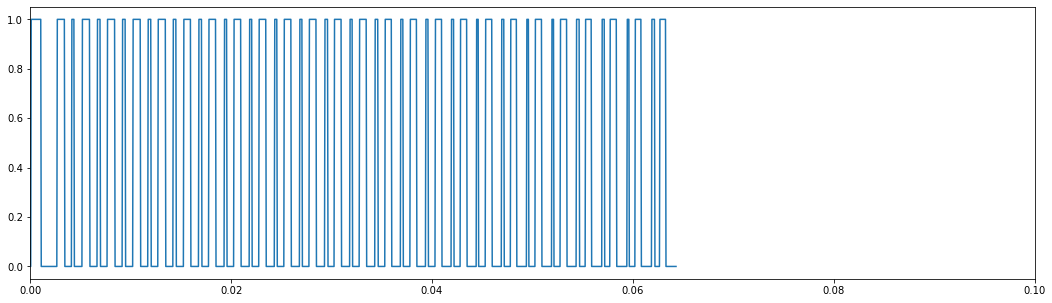

In [9]:
plt.figure(figsize=(18, 5))
plt.plot(ts, actions)
plt.xlim(0, 0.1)
#plt.savefig("v2ppo-CapsuBot-8e6-4envs-force.png", dpi=300)
plt.figsize=(18, 15)

In [56]:
actions = np.array(actions)
rewards = np.array(rewards)
print(actions[:300], "\n")
print("average speed: ", env.average_speed)
print("-----------------------------------------------------------------------------")
print(f"max x position: {np.amax(states[:])} at time {ts[len(ts) - 1:]}")
print("-----------------------------------------------------------------------------")
print(f"max reward: {np.amax(rewards)}")

[0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] 

average speed:  0.002491886941881004
-----------------------------------------------------------------------------
max x position: 0.6081292608747111 at time [0.010699999999999963]
-----------------------------------------------------------------------------
max reward: 500.16336636620656


In [50]:
states[:10]

[array([0., 0., 0., 0.], dtype=float32),
 array([-0.98083652, -0.14198119, -0.09116253,  0.03722914]),
 array([-0.98085017, -0.13898575, -0.08674107,  0.05947579]),
 array([-0.98086364, -0.14082755, -0.07943432,  0.08197412]),
 array([-0.98087868, -0.1406627 , -0.06933854,  0.10316934]),
 array([-0.98089646, -0.14403217, -0.05658988,  0.12377636]),
 array([-0.98090493, -0.14466322, -0.04139029,  0.14237585]),
 array([-0.98091598, -0.14136862, -0.02392318,  0.15849588]),
 array([-0.98092468, -0.14051916, -0.00444024,  0.17306598]),
 array([-0.98093293, -0.14139839,  0.01679385,  0.18575159])]

***
### Testing part ends here
***

In [10]:
actions = np.array(actions)
np.amax(action)
np.sum(actions==0)

10001